In [1]:
import os
import myCudaModule as mcm
import linAlgebraModule as linalg
import scipy.misc as scm
import scipy.ndimage as scnd
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skex
import time
import pycuda.driver as drv
import pycuda.tools as tl
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import sys
import time

Loading the curve

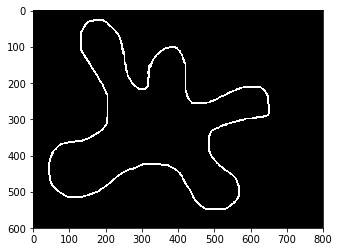

In [2]:
%matplotlib inline
image = scm.imread('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/curve3.jpg').astype(np.float32)
#image = mcm.grayfication(image)
image  = 1- scnd.gaussian_filter(image[:,:,1],2)/255
image[(image<0.5).nonzero()]=0
image[image.nonzero()]=1
plt.imshow(image,cmap='Greys_r')


Function to find the interior of the curve

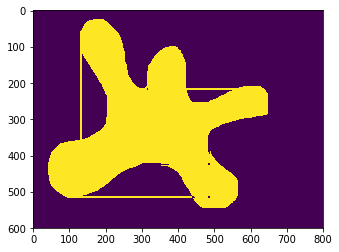

In [3]:
def curveInterior(image):
    forme = image.shape
    if(np.size(forme)>2):
        sys.exit('Only works on gray images')
    

    aSize    = forme[0]*forme[1]
    xdim     = np.int32(forme[0])
    ydim     = np.int32(forme[1])   
    labIm    = np.zeros(forme)    
    
    for i in range(0,xdim):
        arr     = np.array(((image[i,:]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[i,:][trueArr[l]:trueArr[l+1]]=1
                    
    for j in range(0,ydim):
        arr     = np.array(((image[:,j]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[:,j][trueArr[l]:trueArr[l+1]]=1
                #print('we in there'+str(l))
    return labIm
"""    
    for j in range(1,ydim):
            if(labIm[i,j-1]!=0): 
                labIm[i,j]=image[i,j-1]
            else:
                if(image[i-1,j]!=0):
                    labIm[i,j]=image[i-1,j]
                else:
                    Nlab       = Nlab+1
                    labIm[i,j] = Nlab
    for j in range(0,ydim):
        arr     = (1-image[:,j]).nonzero()
        if(np.size(arr)!=0):        
            maxind  = np.max(arr)
            minind  = np.min(arr)
            labIm[:,j][minind:maxind] = 0
"""                        
    
%matplotlib inline
labIm                      = curveInterior(image)
plt.imshow(labIm)
#plt.hist(labIm.ravel())

finding the signed distance function from the curve

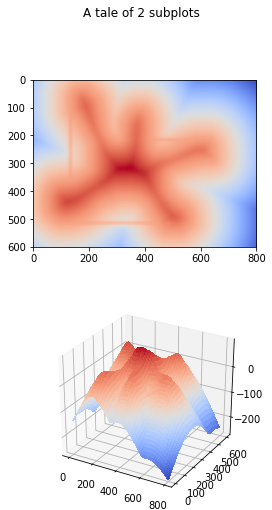

In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
dist                       = scnd.morphology.distance_transform_edt(1-image).astype(np.float32)
dist[(1-labIm).nonzero()]  = -dist[(1-labIm).nonzero()]
#np.loadtxt('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/distance.dat',delimiter=',').astype(np.float32)
#dist = dist/(np.max(dist)-np.min(dist))
dist = scnd.gaussian_filter(dist,6)




fig = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('A tale of 2 subplots')
ax0 = fig.add_subplot(2, 1, 1)
l   = ax0.imshow(dist,cmap='coolwarm')

ax = fig.add_subplot(2, 1, 2, projection='3d')


# Make data.
xdim = image.shape[0]
ydim = image.shape[1]
Y = np.arange(0, xdim, 1)
X = np.arange(0,ydim, 1)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = dist

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap = 'coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.


# Add a color bar which maps values to colors.


plt.show()

Plotting gradients

(-0.5, 799.5, 599.5, -0.5)

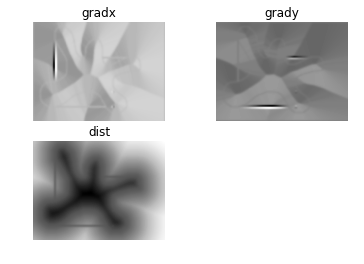

In [6]:
%matplotlib inline
grady, gradx = np.gradient(dist)

gradx[:,ydim-1] = dist[:,ydim-1] -dist[:,ydim-2]
gradx[:,0]      =  dist[:,1]-dist[:,0]
    

grady[xdim-1,:] = dist[xdim-1,:] -dist[xdim-2,:] 
grady[0,:]      = dist[1,:] - dist[0,:]



colmap = 'Greys'
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(gradx,cmap=colmap)
ax0.set_title('gradx')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(grady,cmap=colmap)
ax1.set_title('grady')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(dist,cmap=colmap)
ax2.set_title('dist')
ax2.axis('off')



Using matplotlib backend: TkAgg


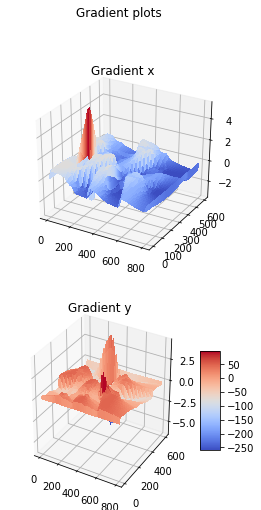

In [7]:
%matplotlib inline


# Make data.
Z    = gradx
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.

# Customize the z axis.


fig   = plt.figure(figsize=plt.figaspect(2.))
fig.suptitle('Gradient plots')
ax0   = fig.add_subplot(2, 1, 1,projection='3d')
ax0.set_title('Gradient x')
surf0 = ax0.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.




Z    = grady
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

ax1 = fig.add_subplot(2, 1, 2, projection='3d')
ax1.set_title('Gradient y')
surf1 = ax1.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()





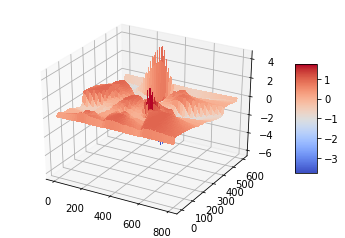

In [8]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
Z    = grady
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.



# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Curve evolution loop


gradxx      = np.zeros((xdim,ydim))
gradxy      = np.zeros((xdim,ydim))
gradyy      = np.zeros((xdim,ydim))
div         = np.zeros((xdim,ydim))
final       = 1*dist

#neumann boundary conditions, set boundary to be 1 index inside the domain and 
#set the 2 neighbouring values to be the same
final[0,:]      = final[1,:]
final[xdim-1,:] = final[xdim-2,:]
final[:,ydim-1] = final[:,ydim-2]
final[:,0]      = final[:,1]
    


maxit       = 20000

timestep    = 0.5

for k in range(0,maxit):

    grady, gradx = np.gradient(final)
    
    normgrad     = gradx**2+grady**2
    
    normgrad[(normgrad<0.0000000001).nonzero()] = 1
    #force gradxx,gradxy,gradyy to be zero on boundary by only calculating it on inside
    gradxx[1:xdim-2,1:ydim-2] = final[1:xdim-2,2:ydim-1] - 2*final[1:xdim-2,1:ydim-2] + final[1:xdim-2,0:ydim-3]
        
    gradyy[1:xdim-2,1:ydim-2] = final[2:xdim-1,1:ydim-2] - 2*final[1:xdim-2,1:ydim-2] + final[0:xdim-3,1:ydim-2]
    
    gradxy[1:xdim-2,1:ydim-2] = (final[2:xdim-1,2:ydim-1] -final[2:xdim-1,0:ydim-3] -final[0:xdim-3,2:ydim-1] + final[0:xdim-3,0:ydim-3]  )/4   

    div    = (gradxx*grady*grady - 2*gradx*grady*gradxy + gradyy*gradx*gradx)/(normgrad)
    div[(normgrad<0.0000000001).nonzero()] = 0
    #div[np.isnan(div)] = 0
    #div[np.isinf(div)] = 0
    final       = timestep*div + final
    # ensures grad=0 on booundary
    final[0,:]      = final[1,:]
    final[xdim-1,:] = final[xdim-2,:]
    final[:,ydim-1] = final[:,ydim-2]
    final[:,0]      = final[:,1]
    
    



%matplotlib qt5
colmap = 'Greys'
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(dist,cmap=colmap)
ax0.set_title('initial conditions')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(final[1:xdim-2,1:ydim-2],cmap=colmap)
ax1.set_title('final state excluding boundary')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(final[1:xdim-2,1:ydim-2]-dist[1:xdim-2,1:ydim-2],cmap=colmap)
ax2.set_title('final-dist')
ax2.axis('off')

ax3 = fig2.add_subplot(224)
ax3.imshow(grady,cmap=colmap)
ax3.set_title('grady')
ax3.axis('off')
plt.show()

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
#Z    = final[1:xdim-2,1:ydim-2]
#Z     = final[1:xdim-2,1:ydim-2]
Z      = div[10:xdim-20,10:ydim-20]
#Z     = final
xdimz = Z.shape[0]
ydimz = Z.shape[1]
Y = np.arange(0, xdimz, 1)
X = np.arange(0,ydimz, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm',
                       linewidth=0, antialiased=False)

# Customize the z axis.



# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

#==============================================================
def findZeros(dist,tol):
    forme = dist.shape
    dimI  = forme[0]
    dimJ  = forme[1]
    
    
    dist       = np.reshape(dist,dimI*dimJ,order = 'F')
    curveArray = np.zeros(dimI*dimJ)
    
    for k in range(0,dimI*dimJ):
        if(dist[k]**2<tol):
            curveArray[k] = 1
            
    curveArray = np.reshape(curveArray,forme,order='F')
    return curveArray
#===============================================================
    
curveInit  = findZeros(dist,0.7)
curveFinal =  findZeros(final,0.5)
    
%matplotlib inline
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(curveInit,cmap=colmap)
ax0.set_title('initial curve')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(curveFinal,cmap=colmap)
ax1.set_title('final curve')
ax1.axis('off')    
    
ax2 = fig2.add_subplot(223)
ax2.imshow(curveFinal+curveInit,cmap=colmap)
ax2.set_title('final+initial curve')
ax2.axis('off') 

In [1]:
#!!!!!!!!!!!!!! parallel version 
import os
import myCudaModule as mcm
import linAlgebraModule as linalg
import scipy.misc as scm
import scipy.ndimage as scnd
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure as skex
import time
import pycuda.driver as drv
import pycuda.tools as tl
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import sys
import time

image = scm.imread('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/curve3.jpg').astype(np.float32)
#image = mcm.grayfication(image)
image  = 1- scnd.gaussian_filter(image[:,:,1],2)/255
image[(image<0.5).nonzero()]=0
image[image.nonzero()]=1

def curveInterior(image):
    forme = image.shape
    if(np.size(forme)>2):
        sys.exit('Only works on gray images')
    

    aSize    = forme[0]*forme[1]
    xdim     = np.int32(forme[0])
    ydim     = np.int32(forme[1])   
    labIm    = np.zeros(forme)    
    
    for i in range(0,xdim):
        arr     = np.array(((image[i,:]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[i,:][trueArr[l]:trueArr[l+1]]=1
                    
    for j in range(0,ydim):
        arr     = np.array(((image[:,j]).nonzero()))
        larr    = np.size(arr)
        if(larr>0):
            trueArr = np.array((arr[0,0]))
            #print('larr='+str(larr))
            for k in range(1,larr):
                #print(k)
                if(arr[0,k]-arr[0,k-1]>1 ): trueArr =  np.append(trueArr,arr[0,k])
            N = np.size(trueArr)
            
            for l in range(0,N-1):
                if(l%2==0): labIm[:,j][trueArr[l]:trueArr[l+1]]=1
                #print('we in there'+str(l))
    return labIm
                       
labIm                      = curveInterior(image)

from mpl_toolkits.mplot3d import Axes3D
dist                       = scnd.morphology.distance_transform_edt(1-image).astype(np.float32)
dist[(1-labIm).nonzero()]  = -dist[(1-labIm).nonzero()]
#np.loadtxt('/home/amr62/Documents/TheEffingPhDHatersGonnaHate/fastmsToying/trialimages/distance.dat',delimiter=',').astype(np.float32)
#dist = dist/(np.max(dist)-np.min(dist))
dist = scnd.gaussian_filter(dist,6)

In [3]:
image    = 1*dist
maxit    = 20000
timestep = 0.1
final    = mcm.onestepIteration(image,timestep,maxit)

Using matplotlib backend: TkAgg


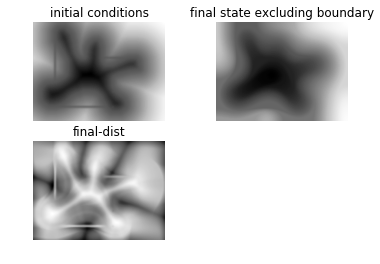

In [11]:
%matplotlib auto
colmap = 'Greys'
forme = image.shape
aSize    = forme[0]*forme[1]
xdim     = np.int32(forme[0])
ydim     = np.int32(forme[1]) 
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(dist,cmap=colmap)
ax0.set_title('initial conditions')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(final[1:xdim-2,1:ydim-2],cmap=colmap)
ax1.set_title('final state excluding boundary')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(final[1:xdim-2,1:ydim-2]-dist[1:xdim-2,1:ydim-2],cmap=colmap)
ax2.set_title('final-dist')
ax2.axis('off')


plt.show()

(-0.5, 799.5, 599.5, -0.5)

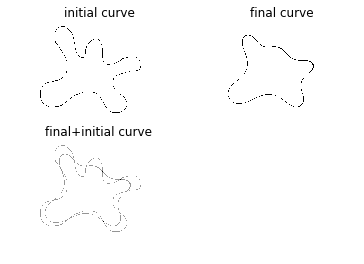

In [10]:
#==============================================================
def findZeros(dist,tol):
    forme = dist.shape
    dimI  = forme[0]
    dimJ  = forme[1]
    
    
    dist       = np.reshape(dist,dimI*dimJ,order = 'F')
    curveArray = np.zeros(dimI*dimJ)
    
    for k in range(0,dimI*dimJ):
        if(dist[k]**2<tol):
            curveArray[k] = 1
            
    curveArray = np.reshape(curveArray,forme,order='F')
    return curveArray
#===============================================================

curveInit  = findZeros(dist,0.7)
curveFinal =  findZeros(final,0.5)
    
%matplotlib inline
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(curveInit,cmap=colmap)
ax0.set_title('initial curve')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(curveFinal,cmap=colmap)
ax1.set_title('final curve')
ax1.axis('off')    
    
ax2 = fig2.add_subplot(223)
ax2.imshow(curveFinal+curveInit,cmap=colmap)
ax2.set_title('final+initial curve')
ax2.axis('off') 

running exevrything on the GPU, so no communication with cpu between itertions, see if it works.

In [2]:
image    = 1*dist
maxit    = 200
timestep = 0.1
final    = mcm.shunshinNoStepIteration(image,timestep,maxit)


LaunchError: cuCtxSynchronize failed: the launch timed out and was terminated

In [ ]:
%matplotlib inline
colmap = 'Greys'
forme = image.shape
aSize    = forme[0]*forme[1]
xdim     = np.int32(forme[0])
ydim     = np.int32(forme[1]) 
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(dist,cmap=colmap)
ax0.set_title('initial conditions')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(final[1:xdim-2,1:ydim-2],cmap=colmap)
ax1.set_title('final state excluding boundary')
ax1.axis('off')


ax2 = fig2.add_subplot(223)
ax2.imshow(final[1:xdim-2,1:ydim-2]-dist[1:xdim-2,1:ydim-2],cmap=colmap)
ax2.set_title('final-dist')
ax2.axis('off')


plt.show()

In [ ]:
#==============================================================
def findZeros(dist,tol):
    forme = dist.shape
    dimI  = forme[0]
    dimJ  = forme[1]
    
    
    dist       = np.reshape(dist,dimI*dimJ,order = 'F')
    curveArray = np.zeros(dimI*dimJ)
    
    for k in range(0,dimI*dimJ):
        if(dist[k]**2<tol):
            curveArray[k] = 1
            
    curveArray = np.reshape(curveArray,forme,order='F')
    return curveArray
#===============================================================

curveInit  = findZeros(dist,0.7)
curveFinal =  findZeros(final,0.5)
    
%matplotlib inline
fig2 = plt.figure(1)

ax0 = fig2.add_subplot(221)
ax0.imshow(curveInit,cmap=colmap)
ax0.set_title('initial curve')
ax0.axis('off')

ax1 = fig2.add_subplot(222)
ax1.imshow(curveFinal,cmap=colmap)
ax1.set_title('final curve')
ax1.axis('off')    
    
ax2 = fig2.add_subplot(223)
ax2.imshow(curveFinal+curveInit,cmap=colmap)
ax2.set_title('final+initial curve')
ax2.axis('off') 